# INM706 - Deep Learning for Sequence Analysis

Authors: Laerte Adami - Elisa Troschka

Source: 
- https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350#30b6
- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#evaluation

Blue Score:
- https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b

from torchtext.data.metrics import bleu_score

candidate_corpus = [['The', 'cat', 'is', 'on','the','table']]
references_corpus = [
    
        [['The', 'cat', 'is', 'on','the','table']]]

print(len(candidate_corpus))
print(len(references_corpus))
    
                    
bleu_score(candidate_corpus, references_corpus,max_n=4, weights=[0.25, 0.25, 0.25,0.25])

In [1]:
# Custom functionalities
from Utilities.lstmHandler import EncoderLSTM, DecoderLSTM, AttentionDecoderLSTM
from Utilities.modelHandler import LSTModel
from Utilities.LanguageDataset import LanguageDataset

import time
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss as CEL
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

plt.rcParams['font.size'] = 17

In [9]:
## DATASET PARAMETERS ##
data_path = "Data/eng_ita.tsv"
limit_data = 10000
start_token = '<BoS>'
end_token = '<EoS>'
seq_len = 10
embedding_size = 256
batch_size = 100

# Import datasets
dataset = LanguageDataset(data_path = data_path, start_token = start_token, end_token = end_token, seq_len = seq_len, limit_data = limit_data)
train_set, val_set, test_set = dataset.get_datasets()

end_index = dataset.from_ita[end_token]
start_index = dataset.from_ita[start_token]

# Create dataloaders
trainloader = DataLoader(train_set, batch_size = batch_size)
valloader = DataLoader(val_set, batch_size = batch_size)
testloader = DataLoader(test_set, batch_size = batch_size)

print("English vocabulary size for training: {}".format(dataset.eng_voc_size))
print("Italian vocabulary size for training: {}".format(dataset.ita_voc_size))
print("--------------------------------------------")
print("Train set dimension: {}".format(train_set.__len__()))
print("Val set dimension: {}".format(val_set.__len__()))
print("Test set dimension: {}".format(test_set.__len__()))

English vocabulary size for training: 3892
Italian vocabulary size for training: 6168
--------------------------------------------
Train set dimension: 6980
Val set dimension: 980
Test set dimension: 2040


EPOCH 1: train loss = 5.043, validation loss = 4.393
EPOCH 2: train loss = 4.328, validation loss = 4.325
EPOCH 3: train loss = 4.19, validation loss = 4.321
EPOCH 4: train loss = 4.072, validation loss = 4.333
EPOCH 5: train loss = 3.952, validation loss = 4.253
EPOCH 6: train loss = 3.845, validation loss = 4.217
EPOCH 7: train loss = 3.708, validation loss = 4.181
EPOCH 8: train loss = 3.553, validation loss = 4.155
EPOCH 9: train loss = 3.386, validation loss = 4.138
EPOCH 10: train loss = 3.231, validation loss = 4.116
--------------------------------
Time required: 14.189102172851562


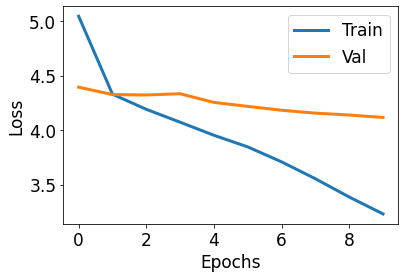

In [11]:
encoder = EncoderLSTM(vocabulary_size = dataset.eng_voc_size,
                     embedding_size = embedding_size,
                     num_layers = 1, 
                     bidirectional = False)

#decoder = DecoderLSTM(vocabulary_size = dataset.ita_voc_size,
#                     embedding_size = embedding_size,
#                     num_layers = 1, 
#                     bidirectional = False)

decoder = AttentionDecoderLSTM(vocabulary_size = dataset.ita_voc_size,
                     embedding_size = embedding_size,
                     seq_len = dataset.seq_len,
                     num_layers = 1, 
                     bidirectional = False)

loss_func = CEL()
model = LSTModel(encoder = encoder, 
                 decoder = decoder, 
                 encoder_optimizer = Adam(encoder.parameters()), 
                 decoder_optimizer = Adam(decoder.parameters()),
                 loss_function = loss_func, 
                 eos_token = end_index, 
                 bos_token = start_index)

start_time = time.time()
L_train, L_val = model.train_model(trainloader,
                      valloader,
                      max_epochs = 10,
                      save_every_epochs = 10,
                      ckp_name = 'test')
print("--------------------------------")
print("Time required: {}".format(time.time()-start_time))
      
fig, ax = plt.subplots()
ax.plot(L_train, linewidth = 3, label = "Train")
ax.plot(L_val, linewidth = 3, label = "Val")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend();

## Evaluation

In [12]:
enc_ckp = "test_enc_10.pth"
dec_ckp = "test_dec_10.pth"

X, y, trans = model.evaluate_model(testloader, max_length = 20, enc_ckp = enc_ckp, dec_ckp = dec_ckp)

In [13]:
ids = 34
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> It is up to you to decide what to
Italian:  <BoS> Sta a te decidere cosa vuoi fare <EoS> <UNK>
Translation:  <BoS> È è che cosa <EoS> <EoS> <UNK> <UNK> <UNK>


In [14]:
ids = 12
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> May I borrow your dictionary <EoS> <UNK> <UNK> <UNK>
Italian:  <BoS> Posso prendere in prestito il tuo vocabolario <EoS> <UNK>
Translation:  <BoS> La il il il la <EoS> <EoS> <UNK> <UNK>


In [15]:
ids = 67
print("English: " + dataset.translate(X[ids],'eng'))
print("Italian: " + dataset.translate(y[ids],'ita'))
print("Translation: " + dataset.translate(trans[ids],'ita'))

English:  <BoS> You re so impatient with me <EoS> <UNK> <UNK>
Italian:  <BoS> È così insofferente con me <EoS> <UNK> <UNK> <UNK>
Translation:  <BoS> Tu dovuto di di <EoS> <EoS> <EoS> <UNK> <UNK>
